# Tarea 2 - Redes: Medidor ancho de banda UDP Go-Back-N
---
### *Pablo Skewes*

## Realización del experimento

In [1]:
from pathlib import Path
from tqdm import tqdm
import os
import sys
import time
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from contextlib import contextmanager
from sklearn.model_selection import ParameterGrid

import jsockets
from go_back_n import compute_bandwidth
from timer import Timer

Definamos las globales para conectarnos al servidor.

In [2]:
FILEPATH = Path('/etc/services').resolve()
SERVER_URL = 'anakena.dcc.uchile.cl'
SERVER_PORT = '1819'

Podemos usar el "main" del programa para realizar un experimento de prueba y ver que todo funciona correctamente.

In [6]:
socket = jsockets.socket_udp_connect(SERVER_URL, SERVER_PORT)

data = compute_bandwidth(
    socket=socket,
    packet_size=4000,
    timeout=10,
    loss=0.1,
    window_size=99,
    filepath=FILEPATH,
    verbose=False,
)

data

{'data_size': 12813,
 'bytes_received': 12813,
 'send_time': 0.07861900329589844,
 'bandwidth': 0.155425895824741}

Vemos que recuperamos un diccionario con los resultados como esperábamos, ahora podemos realizar el experimento completo para distintas combinaciones de valores.

In [7]:
packet_sizes = list(range(1000, 10000, 1000)) + [9999]
window_sizes = [1, 5, 10, 20]
losses = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
timeouts = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

params = ParameterGrid({
    'packet_size': packet_sizes,
    'window_size': window_sizes,
    'loss': losses,
    'timeout': timeouts,
})

print(f"En total hay {len(params)} combinaciones de parámetros")

En total hay 2160 combinaciones de parámetros


In [31]:
results = []

for i, param in tqdm(enumerate(params), total=len(params)):
    verbose = False

    init_time = time.time()
    try:
        socket = jsockets.socket_udp_connect(SERVER_URL, SERVER_PORT)
        if socket is None:
            print("No se pudo abrir el socket")
            sys.exit(1)
            
        if verbose:
            print(f"Experiment {i+1}/{len(params)}")
            print(f"Parameters: {param}")

        data = compute_bandwidth(
            socket=socket,
            packet_size=param['packet_size'],
            timeout=param['timeout'],
            loss=param['loss'],
            window_size=param['window_size'],
            filepath=FILEPATH,
            verbose=verbose,
        )
        
        result = {
            'data_size': data['data_size'],
            'bytes_received': data['bytes_received'],
            'send_time': data['send_time'],
            'bandwidth': data['bandwidth'],
            'packet_size': param['packet_size'],
            'window_size': param['window_size'],
            'loss': param['loss'],
            'timeout': param['timeout'],
        }
        
    except Exception as e:
        # print("Experiment failed with parameters:")
        # print(param)
        result = {
            'data_size': np.nan,
            'bytes_received': np.nan,
            'send_time': np.nan,
            'bandwidth': np.nan,
            'packet_size': param['packet_size'],
            'window_size': param['window_size'],
            'loss': param['loss'],
            'timeout': param['timeout'],
        }
    
    results.append(result)
    
    time.sleep(0.1)

100%|██████████| 2160/2160 [26:40<00:00,  1.35it/s]  


In [ ]:
socket = jsockets.socket_udp_connect(SERVER_URL, SERVER_PORT)

data = compute_bandwidth(
    socket=socket,
    packet_size=4000,
    timeout=10,
    loss=0.3,
    window_size=1,
    filepath=FILEPATH,
    verbose=True,
)

In [36]:
df = pd.DataFrame.from_records(results)

In [3]:
# df.to_csv('results.csv', index=False)
df = pd.read_csv('results.csv')

## Análisis de Resultados

### Experimentos fallidos

In [45]:
perc = df['bandwidth'].isna().sum() / len(df)
print(f"Porcentaje de experimentos fallidos: {perc:.2%}")

failed = df[df['bandwidth'].isna()]

Porcentaje de experimentos fallidos: 10.97%


,data_size,bytes_received,send_time,bandwidth,packet_size,window_size,loss,timeout
0,NaN,NaN,NaN,NaN,1000,1,0.0,1
2,NaN,NaN,NaN,NaN,1000,10,0.0,1
3,NaN,NaN,NaN,NaN,1000,20,0.0,1
36,NaN,NaN,NaN,NaN,2000,1,0.0,1
37,NaN,NaN,NaN,NaN,2000,5,0.0,1
...,...,...,...,...,...,...,...,...
2090,NaN,NaN,NaN,NaN,9000,10,0.5,1
2091,NaN,NaN,NaN,NaN,9000,20,0.5,1
2124,NaN,NaN,NaN,NaN,9999,1,0.5,1
2125,NaN,NaN,NaN,NaN,9999,5,0.5,1


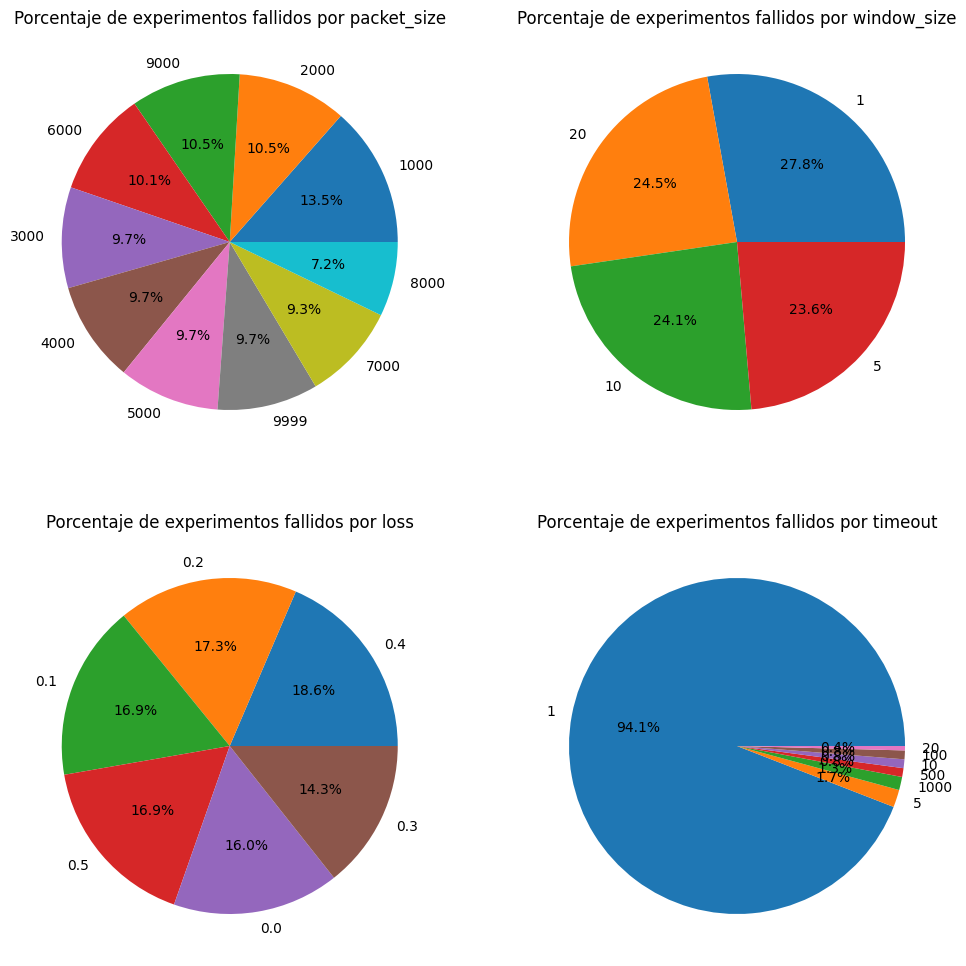

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, param in enumerate(['packet_size', 'window_size', 'loss', 'timeout']):
    failed[param].value_counts().plot.pie(autopct='%1.1f%%', ax=axs[i])
    axs[i].set_title(f'Porcentaje de experimentos fallidos por {param}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
      

Podemos ver que de 2100 experimentos aproximadamente, unos 200 fallaraon y fueron principalmente por problemas de timeout, parece ser que 1ms es muy poco para que el servidor alcance a responder.

Ahora podemos eliminar los experimentos que fallaron para analizar los resultados.

In [58]:
df = df.dropna().reset_index(drop=True)

## Pérdida de paquetes

In [63]:
(df['data_size'] - df['bytes_received']).sum()

0.0

De los datos podemos ver que ningún experimento tuvo pérdida de paquetes, esto es porque el protocolo Go-Back-N tiene un mecanismo de retransmisión de paquetes que permite recuperarse de pérdidas de paquetes. Aunque no podremos estar 100% seguros de que no haya habido ningún error, podemos decir que la probabilidad de que haya ocurrido es muy baja y que los experimentos fueron exitosos.

In [35]:
df

,data_size,bytes_received,send_time,bandwidth,packet_size,window_size,loss,timeout
0,12813.0,12813.0,0.025270,0.483550,1000,5,0.0,1
1,12813.0,12813.0,0.137159,0.089089,1000,1,0.0,5
2,12813.0,12813.0,0.025814,0.473372,1000,5,0.0,5
3,12813.0,12813.0,0.027213,0.449024,1000,10,0.0,5
4,12813.0,12813.0,0.015599,0.783358,1000,20,0.0,5
...,...,...,...,...,...,...,...,...
1918,12813.0,12813.0,2.083974,0.005864,9999,20,0.5,500
1919,12813.0,12813.0,0.033921,0.360227,9999,1,0.5,1000
1920,12813.0,12813.0,2.053771,0.005950,9999,5,0.5,1000
1921,12813.0,12813.0,3.020338,0.004046,9999,10,0.5,1000


## Comparación con otros clientes

### Stop and Wait

In [4]:
def get_number_regx(s):
    return ''.join([c for c in s if c.isdigit()])

@contextmanager
def supress_stdout():
    old_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, 'w')
        yield
    finally:
        sys.stdout = old_stdout

In [5]:
def execute_stop_and_wait(size: int, timeout: int, loss: float, filepath: str, server_url: str, server_port: str):
    try:
        cmd = f"python bwc-sw.py {size} {timeout} {loss} {filepath} {server_url} {server_port}"
        with supress_stdout():
            output = subprocess.check_output(cmd, shell=True)
        output = output.decode('utf-8')
        output = output.split('\n')[-2]
        output = output.split(', ')
    except Exception as e:
        print(e)
        return {
            'bytes_received': np.nan,
            'send_time': np.nan,
            'bandwidth': np.nan,
        }
    return {
        'bytes_received': int(get_number_regx(output[0])),
        'send_time': float(get_number_regx(output[1])),
        'bandwidth': float(get_number_regx(output[2]))
    }

data = execute_stop_and_wait(
    size=5000,
    timeout=20,
    loss=int(0.1 * 100),
    filepath=FILEPATH,
    server_url=SERVER_URL,
    server_port=SERVER_PORT,
)

data
    
    

propuse paquete: 5000
recibo paquete: 5000


{'bytes_received': 12813,
 'send_time': 6043672561645508.0,
 'bandwidth': 2.021854905518955e+16}

Logramos transformar el script dado en clases para el cliente StopAndWait en una función que devuelva los valores en un diccionario para poder compararlos con los resultados del cliente Go-Back-N.

In [8]:
print(f"Vamos a probar el cliente con los siguientes parámetros:")
print(f"{packet_sizes=}")
print(f"{timeouts=}")
print(f"{losses=}")

Vamos a probar el cliente con los siguientes parámetros:
packet_sizes=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999]
timeouts=[1, 5, 10, 20, 50, 100, 200, 500, 1000]
losses=[0, 0.1, 0.2, 0.3, 0.4, 0.5]


In [9]:
params_stop_and_wait = ParameterGrid({
    'packet_size': packet_sizes,
    'timeout': timeouts,
    'loss': losses,
})
print(f"En total hay {len(params_stop_and_wait)} combinaciones de parámetros")

En total hay 540 combinaciones de parámetros


In [10]:
results_stop_and_wait = []
for i, param in tqdm(enumerate(params_stop_and_wait), total=len(params_stop_and_wait)):
    verbose = False
    try:
        data = execute_stop_and_wait(
            size=param['packet_size'],
            timeout=param['timeout'],
            loss=int(param['loss'] * 100),
            filepath=FILEPATH,
            server_url=SERVER_URL,
            server_port=SERVER_PORT,
        )
        
        # print(data)
        
        result = {
            'data_size': 12813.0,
            'bytes_received': data['bytes_received'],
            'send_time': data['send_time'],
            'bandwidth': data['bandwidth'],
            'packet_size': param['packet_size'],
            'timeout': param['timeout'],
            'loss': param['loss'],
        }
        
    except Exception as e:
        # print("Experiment failed with parameters:")
        # print(param)
        # traceback = sys.exc_info()[2]
        # print(f"Traceback: {traceback.tb_frame.f_code.co_filename}:{traceback.tb_lineno}")
        result = {
            'data_size': np.nan,
            'bytes_received': np.nan,
            'send_time': np.nan,
            'bandwidth': np.nan,
            'packet_size': param['packet_size'],
            'timeout': param['timeout'],
        }
    
    results_stop_and_wait.append(result)
    
    time.sleep(0.1)

  0%|          | 0/540 [00:00<?, ?it/s]propuse paquete: 1000
recibo paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 60, in send_loss
    s.send(data)
TimeoutError: timed out
  0%|          | 1/540 [00:00<02:41,  3.33it/s]

Command 'python bwc-sw.py 1000 1 0 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
recibo paquete: 1000
  0%|          | 2/540 [00:00<02:30,  3.58it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|          | 3/540 [00:00<02:43,  3.28it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|          | 4/540 [00:01<02:36,  3.42it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|          | 5/540 [00:01<02:37,  3.40it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|          | 6/540 [00:01<02:40,  3.33it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|▏         | 7/540 [00:02<02:37,  3.39it/s]propuse paquete: 1000
recibo paquete: 1000
  1%|▏         | 8/540 [00:02<02:38,  3.35it/s]propuse paquete: 1000
recibo paquete: 1000
  2%|▏         | 9/540 [00:02<02:39,  3.33it/s]propuse paquete: 2000
recibo paquete: 2000
  2%|▏         | 10/540 [00:02<02:37,  3.37it/s]

Command 'python bwc-sw.py 2000 1 0 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
recibo paquete: 2000
  2%|▏         | 11/540 [00:03<02:27,  3.59it/s]propuse paquete: 2000
recibo paquete: 2000
  2%|▏         | 12/540 [00:03<02:18,  3.81it/s]propuse paquete: 2000
recibo paquete: 2000
  2%|▏         | 13/540 [00:03<02:17,  3.84it/s]propuse paquete: 2000
recibo paquete: 2000
  3%|▎         | 14/540 [00:03<02:11,  4.00it/s]propuse paquete: 2000
recibo paquete: 2000
  3%|▎         | 15/540 [00:04<02:08,  4.07it/s]propuse paquete: 2000
recibo paquete: 2000
  3%|▎         | 16/540 [00:04<02:05,  4.18it/s]propuse paquete: 2000
recibo paquete: 2000
  3%|▎         | 17/540 [00:04<02:08,  4.08it/s]propuse paquete: 2000
recibo paquete: 2000
  3%|▎         | 18/540 [00:04<02:08,  4.05it/s]propuse paquete: 3000
recibo paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py"

Command 'python bwc-sw.py 3000 1 0 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
  4%|▎         | 20/540 [00:05<02:08,  4.06it/s]propuse paquete: 3000
recibo paquete: 3000
  4%|▍         | 21/540 [00:05<02:03,  4.21it/s]propuse paquete: 3000
recibo paquete: 3000
  4%|▍         | 22/540 [00:05<02:02,  4.23it/s]propuse paquete: 3000
recibo paquete: 3000
  4%|▍         | 23/540 [00:06<01:58,  4.37it/s]propuse paquete: 3000
recibo paquete: 3000
  4%|▍         | 24/540 [00:06<01:54,  4.52it/s]propuse paquete: 3000
recibo paquete: 3000
  5%|▍         | 25/540 [00:06<01:52,  4.58it/s]propuse paquete: 3000
recibo paquete: 3000
  5%|▍         | 26/540 [00:06<01:56,  4.40it/s]propuse paquete: 3000
recibo paquete: 3000
  5%|▌         | 27/540 [00:06<02:00,  4.26it/s]propuse paquete: 4000
recibo paquete: 4000
  5%|▌         | 28/540 [00:07<02:04,  4.12it/s]propuse paquete: 4000
recibo paquete: 4000
  5%|▌         | 29/540 [00:07<01:56,  4.37it/s]propuse paquete: 4000
recibo paquete: 4000
  6%|▌         | 30/540 [00:07<01:50,  4.61it/s

Command 'python bwc-sw.py 1000 200 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 18%|█▊        | 98/540 [00:35<23:24,  3.18s/it]propuse paquete: 1000
recibo paquete: 1000
 18%|█▊        | 99/540 [00:36<19:09,  2.61s/it]propuse paquete: 2000
recibo paquete: 2000
 19%|█▊        | 100/540 [00:36<13:56,  1.90s/it]propuse paquete: 2000
recibo paquete: 2000
 19%|█▊        | 101/540 [00:37<10:20,  1.41s/it]propuse paquete: 2000
recibo paquete: 2000
 19%|█▉        | 102/540 [00:37<07:44,  1.06s/it]propuse paquete: 2000
recibo paquete: 2000
 19%|█▉        | 103/540 [00:37<05:57,  1.22it/s]propuse paquete: 2000
recibo paquete: 2000
 19%|█▉        | 104/540 [00:37<05:03,  1.44it/s]propuse paquete: 2000
recibo paquete: 2000
 19%|█▉        | 105/540 [00:38<04:33,  1.59it/s]propuse paquete: 2000
recibo paquete: 2000
 20%|█▉        | 106/540 [00:39<04:34,  1.58it/s]propuse paquete: 2000
recibo paquete: 2000
 20%|█▉        | 107/540 [00:45<17:50,  2.47s/it]propuse paquete: 2000
recibo paquete: 2000
 20%|██        | 108/540 [00:49<19:30,  2.71s/it]propuse paquete: 3000
recibo paqu

Command 'python bwc-sw.py 4000 20 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 23%|██▎       | 122/540 [01:08<17:54,  2.57s/it]propuse paquete: 4000
recibo paquete: 4000
 23%|██▎       | 123/540 [01:08<12:58,  1.87s/it]propuse paquete: 4000
recibo paquete: 4000
 23%|██▎       | 124/540 [01:09<09:52,  1.42s/it]propuse paquete: 4000
recibo paquete: 4000
 23%|██▎       | 125/540 [01:09<07:22,  1.07s/it]propuse paquete: 4000
recibo paquete: 4000
 23%|██▎       | 126/540 [01:10<07:42,  1.12s/it]propuse paquete: 5000
recibo paquete: 5000
 24%|██▎       | 127/540 [01:10<05:53,  1.17it/s]propuse paquete: 5000
recibo paquete: 5000
 24%|██▎       | 128/540 [01:11<04:30,  1.52it/s]propuse paquete: 5000
recibo paquete: 5000
 24%|██▍       | 129/540 [01:11<03:31,  1.94it/s]propuse paquete: 5000
recibo paquete: 5000
 24%|██▍       | 130/540 [01:11<03:22,  2.02it/s]propuse paquete: 5000
recibo paquete: 5000
 24%|██▍       | 131/540 [01:12<03:50,  1.77it/s]propuse paquete: 5000
recibo paquete: 5000
 24%|██▍       | 132/540 [01:12<03:29,  1.95it/s]propuse paquete: 5000
recibo pa

Command 'python bwc-sw.py 7000 1 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
recibo paquete: 7000
 27%|██▋       | 146/540 [01:18<02:46,  2.37it/s]propuse paquete: 7000
recibo paquete: 7000
 27%|██▋       | 147/540 [01:18<02:18,  2.84it/s]propuse paquete: 7000
recibo paquete: 7000
 27%|██▋       | 148/540 [01:19<02:02,  3.21it/s]propuse paquete: 7000
recibo paquete: 7000
 28%|██▊       | 149/540 [01:19<01:48,  3.61it/s]propuse paquete: 7000
recibo paquete: 7000
 28%|██▊       | 150/540 [01:19<01:38,  3.98it/s]propuse paquete: 7000
recibo paquete: 7000
 28%|██▊       | 151/540 [01:19<01:32,  4.22it/s]propuse paquete: 7000
recibo paquete: 7000
 28%|██▊       | 152/540 [01:19<01:28,  4.37it/s]propuse paquete: 7000
recibo paquete: 7000
 28%|██▊       | 153/540 [01:21<03:20,  1.93it/s]propuse paquete: 8000
recibo paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bw

Command 'python bwc-sw.py 8000 1 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 29%|██▊       | 155/540 [01:21<02:17,  2.79it/s]propuse paquete: 8000
recibo paquete: 8000
 29%|██▉       | 156/540 [01:21<02:00,  3.20it/s]propuse paquete: 8000
recibo paquete: 8000
 29%|██▉       | 157/540 [01:22<02:13,  2.87it/s]propuse paquete: 8000
recibo paquete: 8000
 29%|██▉       | 158/540 [01:22<01:56,  3.27it/s]propuse paquete: 8000
recibo paquete: 8000
 29%|██▉       | 159/540 [01:22<01:43,  3.68it/s]propuse paquete: 8000
recibo paquete: 8000
 30%|██▉       | 160/540 [01:22<01:56,  3.27it/s]propuse paquete: 8000
recibo paquete: 8000
 30%|██▉       | 161/540 [01:23<02:42,  2.34it/s]propuse paquete: 8000
recibo paquete: 8000
 30%|███       | 162/540 [01:23<02:13,  2.83it/s]propuse paquete: 9000
recibo paquete: 9000
 30%|███       | 164/540 [01:29<11:10,  1.78s/it]

Command 'python bwc-sw.py 9000 5 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
recibo paquete: 9000
 31%|███       | 165/540 [01:29<08:20,  1.34s/it]propuse paquete: 9000
recibo paquete: 9000
 31%|███       | 166/540 [01:29<06:10,  1.01it/s]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 31%|███       | 167/540 [01:39<23:20,  3.76s/it]propuse paquete: 9000
recibo paquete: 9000


Command 'python bwc-sw.py 9000 50 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 31%|███       | 168/540 [01:40<16:39,  2.69s/it]propuse paquete: 9000
recibo paquete: 9000
 31%|███▏      | 169/540 [01:40<12:05,  1.96s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 31%|███▏      | 170/540 [01:50<27:18,  4.43s/it]propuse paquete: 9000
recibo paquete: 9000


Command 'python bwc-sw.py 9000 500 10 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 32%|███▏      | 171/540 [01:51<21:19,  3.47s/it]propuse paquete: 9999
recibo paquete: 9000
 32%|███▏      | 172/540 [01:52<15:16,  2.49s/it]propuse paquete: 9999
recibo paquete: 9000
 32%|███▏      | 173/540 [01:52<11:00,  1.80s/it]propuse paquete: 9999
recibo paquete: 9000
 32%|███▏      | 174/540 [01:52<08:04,  1.32s/it]propuse paquete: 9999
recibo paquete: 9000
 32%|███▏      | 175/540 [01:52<06:03,  1.00it/s]propuse paquete: 9999
recibo paquete: 9000
 33%|███▎      | 176/540 [01:52<04:49,  1.26it/s]propuse paquete: 9999
recibo paquete: 9000
 33%|███▎      | 177/540 [01:53<03:43,  1.62it/s]propuse paquete: 9999
recibo paquete: 9000
 33%|███▎      | 178/540 [01:53<03:19,  1.82it/s]propuse paquete: 9999
recibo paquete: 9000
 33%|███▎      | 179/540 [01:53<02:41,  2.24it/s]propuse paquete: 9999
recibo paquete: 9000
 34%|███▎      | 181/540 [01:55<03:41,  1.62it/s]

Command 'python bwc-sw.py 1000 1 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
recibo paquete: 1000
 34%|███▎      | 182/540 [01:55<03:09,  1.89it/s]propuse paquete: 1000
recibo paquete: 1000
 34%|███▍      | 183/540 [01:55<02:55,  2.04it/s]propuse paquete: 1000
recibo paquete: 1000
 34%|███▍      | 184/540 [01:56<02:56,  2.02it/s]propuse paquete: 1000
recibo paquete: 1000
 34%|███▍      | 185/540 [01:57<03:14,  1.82it/s]propuse paquete: 1000
recibo paquete: 1000
 34%|███▍      | 186/540 [01:57<03:41,  1.60it/s]propuse paquete: 1000
recibo paquete: 1000
 35%|███▍      | 187/540 [02:00<06:25,  1.09s/it]propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 35%|███▍      | 188/540 [02:10<22:24,  3.82s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 1000 500 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 35%|███▌      | 189/540 [02:17<28:30,  4.87s/it]propuse paquete: 2000
recibo paquete: 2000
 35%|███▌      | 190/540 [02:17<20:20,  3.49s/it]propuse paquete: 2000
recibo paquete: 2000
 35%|███▌      | 191/540 [02:18<14:36,  2.51s/it]propuse paquete: 2000
recibo paquete: 2000
 36%|███▌      | 192/540 [02:18<10:45,  1.85s/it]propuse paquete: 2000
recibo paquete: 2000
 36%|███▌      | 193/540 [02:18<08:06,  1.40s/it]propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 36%|███▌      | 194/540 [02:28<23:21,  4.05s/it]propuse paquete: 2000
recibo paquete: 2000


Command 'python bwc-sw.py 2000 50 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 36%|███▌      | 195/540 [02:29<17:38,  3.07s/it]propuse paquete: 2000
recibo paquete: 2000
 36%|███▋      | 196/540 [02:33<18:37,  3.25s/it]propuse paquete: 2000
recibo paquete: 2000
 36%|███▋      | 197/540 [02:41<27:14,  4.77s/it]propuse paquete: 2000
recibo paquete: 2000
 37%|███▋      | 198/540 [02:44<24:35,  4.31s/it]propuse paquete: 3000
recibo paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 60, in send_loss
    s.send(data)
TimeoutError: timed out
 37%|███▋      | 199/540 [02:45<17:35,  3.10s/it]

Command 'python bwc-sw.py 3000 1 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 37%|███▋      | 201/540 [02:55<26:14,  4.65s/it]

Command 'python bwc-sw.py 3000 10 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 37%|███▋      | 202/540 [02:55<18:45,  3.33s/it]propuse paquete: 3000
recibo paquete: 3000
 38%|███▊      | 203/540 [02:57<15:56,  2.84s/it]propuse paquete: 3000
recibo paquete: 3000
 38%|███▊      | 204/540 [02:58<11:39,  2.08s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 38%|███▊      | 205/540 [03:08<25:10,  4.51s/it]

Command 'python bwc-sw.py 3000 200 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 38%|███▊      | 206/540 [03:15<30:30,  5.48s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 38%|███▊      | 207/540 [03:26<38:12,  6.89s/it]propuse paquete: 4000
recibo paquete: 4000


Command 'python bwc-sw.py 3000 1000 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 60, in send_loss
    s.send(data)
TimeoutError: timed out
 39%|███▊      | 208/540 [03:26<27:02,  4.89s/it]

Command 'python bwc-sw.py 4000 1 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 39%|███▊      | 209/540 [03:26<19:21,  3.51s/it]propuse paquete: 4000
recibo paquete: 4000
 39%|███▉      | 210/540 [03:26<13:51,  2.52s/it]propuse paquete: 4000
recibo paquete: 4000
 39%|███▉      | 211/540 [03:27<10:25,  1.90s/it]propuse paquete: 4000
recibo paquete: 4000
 39%|███▉      | 212/540 [03:29<10:07,  1.85s/it]propuse paquete: 4000
recibo paquete: 4000
 39%|███▉      | 213/540 [03:29<07:26,  1.36s/it]propuse paquete: 4000
recibo paquete: 4000
 40%|███▉      | 214/540 [03:30<06:30,  1.20s/it]propuse paquete: 4000
recibo paquete: 4000
 40%|███▉      | 215/540 [03:30<05:41,  1.05s/it]propuse paquete: 4000
recibo paquete: 4000
 40%|████      | 216/540 [03:31<05:56,  1.10s/it]propuse paquete: 5000
recibo paquete: 5000
 40%|████      | 218/540 [03:37<11:36,  2.16s/it]

Command 'python bwc-sw.py 5000 5 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 41%|████      | 219/540 [03:47<24:29,  4.58s/it]

Command 'python bwc-sw.py 5000 10 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
recibo paquete: 5000
 41%|████      | 220/540 [03:47<17:27,  3.27s/it]propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 41%|████      | 221/540 [03:58<28:27,  5.35s/it]propuse paquete: 5000
recibo paquete: 5000


Command 'python bwc-sw.py 5000 50 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 41%|████      | 222/540 [03:58<21:11,  4.00s/it]propuse paquete: 5000
recibo paquete: 5000
 41%|████▏     | 223/540 [03:59<16:23,  3.10s/it]propuse paquete: 5000
recibo paquete: 5000
 41%|████▏     | 224/540 [04:00<12:35,  2.39s/it]propuse paquete: 5000
recibo paquete: 5000
 42%|████▏     | 225/540 [04:00<09:08,  1.74s/it]propuse paquete: 6000
recibo paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 60, in send_loss
    s.send(data)
TimeoutError: timed out
 42%|████▏     | 226/540 [04:01<06:41,  1.28s/it]propuse paquete: 6000
recibo paquete: 6000


Command 'python bwc-sw.py 6000 1 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 42%|████▏     | 227/540 [04:01<05:03,  1.03it/s]propuse paquete: 6000
recibo paquete: 6000
 42%|████▏     | 228/540 [04:01<03:53,  1.33it/s]propuse paquete: 6000
recibo paquete: 6000
 42%|████▏     | 229/540 [04:01<03:09,  1.64it/s]propuse paquete: 6000
recibo paquete: 6000
 43%|████▎     | 230/540 [04:02<02:39,  1.94it/s]propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 43%|████▎     | 231/540 [04:12<17:34,  3.41s/it]propuse paquete: 6000
recibo paquete: 6000


Command 'python bwc-sw.py 6000 100 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 43%|████▎     | 232/540 [04:13<14:09,  2.76s/it]propuse paquete: 6000
recibo paquete: 6000
 43%|████▎     | 233/540 [04:14<10:56,  2.14s/it]propuse paquete: 6000
recibo paquete: 6000
 43%|████▎     | 234/540 [04:14<07:59,  1.57s/it]propuse paquete: 7000
recibo paquete: 7000
 44%|████▎     | 236/540 [04:19<12:00,  2.37s/it]

Command 'python bwc-sw.py 7000 5 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
recibo paquete: 7000
 44%|████▍     | 237/540 [04:20<08:48,  1.74s/it]propuse paquete: 7000
recibo paquete: 7000
 44%|████▍     | 238/540 [04:20<06:27,  1.28s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 44%|████▍     | 239/540 [04:30<19:53,  3.96s/it]propuse paquete: 7000
recibo paquete: 7000


Command 'python bwc-sw.py 7000 50 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 44%|████▍     | 240/540 [04:30<14:08,  2.83s/it]propuse paquete: 7000
recibo paquete: 7000
 45%|████▍     | 241/540 [04:31<10:32,  2.12s/it]propuse paquete: 7000
recibo paquete: 7000
 45%|████▍     | 242/540 [04:31<08:23,  1.69s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 45%|████▌     | 243/540 [04:42<20:55,  4.23s/it]propuse paquete: 8000
recibo paquete: 8000


Command 'python bwc-sw.py 7000 1000 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 150, in <module>
    send_loss(s, b"D" + to_seq(cnt) + data)
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 60, in send_loss
    s.send(data)
TimeoutError: timed out
 45%|████▌     | 244/540 [04:42<14:54,  3.02s/it]propuse paquete: 8000
recibo paquete: 8000


Command 'python bwc-sw.py 8000 1 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 45%|████▌     | 245/540 [04:42<10:41,  2.18s/it]propuse paquete: 8000
recibo paquete: 8000
 46%|████▌     | 246/540 [04:42<07:45,  1.58s/it]propuse paquete: 8000
recibo paquete: 8000
 46%|████▌     | 247/540 [04:42<05:40,  1.16s/it]propuse paquete: 8000
recibo paquete: 8000
 46%|████▌     | 248/540 [04:43<04:47,  1.02it/s]propuse paquete: 8000
recibo paquete: 8000
 46%|████▌     | 249/540 [04:43<04:06,  1.18it/s]propuse paquete: 8000
recibo paquete: 8000
 46%|████▋     | 250/540 [04:44<03:11,  1.52it/s]propuse paquete: 8000
recibo paquete: 8000
 46%|████▋     | 251/540 [04:44<03:16,  1.47it/s]propuse paquete: 8000
recibo paquete: 8000
 47%|████▋     | 252/540 [04:48<06:58,  1.45s/it]propuse paquete: 9000
recibo paquete: 9000
 47%|████▋     | 253/540 [04:48<05:29,  1.15s/it]propuse paquete: 9000
recibo paquete: 9000
 47%|████▋     | 254/540 [04:48<04:10,  1.14it/s]propuse paquete: 9000
recibo paquete: 9000
 47%|████▋     | 255/540 [04:49<03:12,  1.48it/s]propuse paquete: 9000
recibo pa

Command 'python bwc-sw.py 9000 200 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 48%|████▊     | 260/540 [05:01<12:47,  2.74s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 48%|████▊     | 261/540 [05:11<23:06,  4.97s/it]propuse paquete: 9999
recibo paquete: 9000


Command 'python bwc-sw.py 9000 1000 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 49%|████▊     | 262/540 [05:11<16:24,  3.54s/it]propuse paquete: 9999
recibo paquete: 9000
 49%|████▊     | 263/540 [05:12<11:47,  2.55s/it]propuse paquete: 9999
recibo paquete: 9000
 49%|████▉     | 264/540 [05:12<08:29,  1.85s/it]propuse paquete: 9999
recibo paquete: 9000
 49%|████▉     | 265/540 [05:12<06:11,  1.35s/it]propuse paquete: 9999
recibo paquete: 9000
 49%|████▉     | 266/540 [05:12<04:43,  1.03s/it]propuse paquete: 9999
recibo paquete: 9000
 49%|████▉     | 267/540 [05:13<04:00,  1.14it/s]propuse paquete: 9999
recibo paquete: 9000
 50%|████▉     | 268/540 [05:13<03:36,  1.26it/s]propuse paquete: 9999
recibo paquete: 9000
 50%|████▉     | 269/540 [05:14<03:28,  1.30it/s]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 50%|█████     | 270/54

Command 'python bwc-sw.py 9999 1000 20 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 50%|█████     | 271/540 [05:25<11:39,  2.60s/it]propuse paquete: 1000
recibo paquete: 1000
 50%|█████     | 272/540 [05:25<08:40,  1.94s/it]propuse paquete: 1000
recibo paquete: 1000
 51%|█████     | 273/540 [05:25<06:34,  1.48s/it]propuse paquete: 1000
recibo paquete: 1000
 51%|█████     | 274/540 [05:26<05:37,  1.27s/it]propuse paquete: 1000
recibo paquete: 1000
 51%|█████     | 275/540 [05:27<05:02,  1.14s/it]propuse paquete: 1000
recibo paquete: 1000
 51%|█████     | 276/540 [05:28<05:08,  1.17s/it]propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 51%|█████▏    | 277/540 [05:39<17:00,  3.88s/it]

Command 'python bwc-sw.py 1000 200 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 51%|█████▏    | 278/540 [05:49<25:11,  5.77s/it]

Command 'python bwc-sw.py 1000 500 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 52%|█████▏    | 279/540 [05:59<30:50,  7.09s/it]propuse paquete: 2000
recibo paquete: 2000


Command 'python bwc-sw.py 1000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 52%|█████▏    | 280/540 [05:59<21:48,  5.03s/it]propuse paquete: 2000
recibo paquete: 2000
 52%|█████▏    | 281/540 [05:59<15:37,  3.62s/it]propuse paquete: 2000
recibo paquete: 2000
 52%|█████▏    | 282/540 [06:00<11:16,  2.62s/it]propuse paquete: 2000
recibo paquete: 2000
 52%|█████▏    | 283/540 [06:00<08:17,  1.94s/it]propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 53%|█████▎    | 284/540 [06:10<18:49,  4.41s/it]

Command 'python bwc-sw.py 2000 50 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 53%|█████▎    | 285/540 [06:20<26:06,  6.14s/it]

Command 'python bwc-sw.py 2000 100 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
recibo paquete: 2000
 53%|█████▎    | 286/540 [06:25<23:56,  5.66s/it]propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 53%|█████▎    | 287/540 [06:35<29:34,  7.01s/it]

Command 'python bwc-sw.py 2000 500 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 53%|█████▎    | 288/540 [06:45<33:26,  7.96s/it]propuse paquete: 3000
recibo paquete: 3000


Command 'python bwc-sw.py 2000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 54%|█████▎    | 289/540 [06:46<23:40,  5.66s/it]propuse paquete: 3000
recibo paquete: 3000
 54%|█████▍    | 291/540 [06:56<24:28,  5.90s/it]

Command 'python bwc-sw.py 3000 10 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 54%|█████▍    | 292/540 [06:57<17:46,  4.30s/it]propuse paquete: 3000
recibo paquete: 3000
 54%|█████▍    | 293/540 [06:57<13:13,  3.21s/it]propuse paquete: 3000
recibo paquete: 3000
 54%|█████▍    | 294/540 [07:00<12:53,  3.14s/it]propuse paquete: 3000
recibo paquete: 3000
 55%|█████▍    | 295/540 [07:01<10:18,  2.52s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 55%|█████▍    | 296/540 [07:12<19:34,  4.81s/it]

Command 'python bwc-sw.py 3000 500 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 55%|█████▌    | 297/540 [07:22<25:59,  6.42s/it]propuse paquete: 4000
recibo paquete: 4000


Command 'python bwc-sw.py 3000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 55%|█████▌    | 298/540 [07:22<18:23,  4.56s/it]propuse paquete: 4000
recibo paquete: 4000
 55%|█████▌    | 299/540 [07:22<13:05,  3.26s/it]propuse paquete: 4000
recibo paquete: 4000
 56%|█████▌    | 300/540 [07:23<09:36,  2.40s/it]propuse paquete: 4000
recibo paquete: 4000
 56%|█████▌    | 301/540 [07:23<07:04,  1.77s/it]propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 56%|█████▌    | 302/540 [07:33<17:01,  4.29s/it]

Command 'python bwc-sw.py 4000 50 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 56%|█████▌    | 303/540 [07:43<23:57,  6.06s/it]

Command 'python bwc-sw.py 4000 100 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 56%|█████▋    | 304/540 [07:46<20:01,  5.09s/it]propuse paquete: 4000
recibo paquete: 4000
 56%|█████▋    | 305/540 [07:48<16:34,  4.23s/it]propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 57%|█████▋    | 306/540 [07:58<23:26,  6.01s/it]

Command 'python bwc-sw.py 4000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
recibo paquete: 5000
 57%|█████▋    | 307/540 [07:59<16:37,  4.28s/it]propuse paquete: 5000
recibo paquete: 5000
 57%|█████▋    | 308/540 [07:59<11:49,  3.06s/it]propuse paquete: 5000
recibo paquete: 5000
 57%|█████▋    | 309/540 [07:59<08:32,  2.22s/it]propuse paquete: 5000
recibo paquete: 5000
 57%|█████▋    | 310/540 [08:00<06:31,  1.70s/it]propuse paquete: 5000
recibo paquete: 5000
 58%|█████▊    | 311/540 [08:01<05:50,  1.53s/it]propuse paquete: 5000
recibo paquete: 5000
 58%|█████▊    | 312/540 [08:01<04:33,  1.20s/it]propuse paquete: 5000
recibo paquete: 5000
 58%|█████▊    | 313/540 [08:02<04:32,  1.20s/it]propuse paquete: 5000
recibo paquete: 5000
 58%|█████▊    | 314/540 [08:09<10:47,  2.86s/it]propuse paquete: 5000
recibo paquete: 5000
 59%|█████▊    | 316/540 [08:20<13:52,  3.72s/it]

Command 'python bwc-sw.py 6000 1 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 59%|█████▉    | 318/540 [08:30<18:19,  4.95s/it]

Command 'python bwc-sw.py 6000 10 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 59%|█████▉    | 319/540 [08:31<13:05,  3.55s/it]propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 59%|█████▉    | 320/540 [08:41<20:22,  5.55s/it]

Command 'python bwc-sw.py 6000 50 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 59%|█████▉    | 321/540 [08:51<25:20,  6.94s/it]

Command 'python bwc-sw.py 6000 100 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 60%|█████▉    | 322/540 [09:01<28:45,  7.91s/it]propuse paquete: 6000
recibo paquete: 6000


Command 'python bwc-sw.py 6000 200 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 60%|█████▉    | 323/540 [09:04<23:02,  6.37s/it]propuse paquete: 6000
recibo paquete: 6000
 60%|██████    | 324/540 [09:06<18:26,  5.12s/it]propuse paquete: 7000
recibo paquete: 7000
 60%|██████    | 325/540 [09:06<13:04,  3.65s/it]propuse paquete: 7000
recibo paquete: 7000
 60%|██████    | 326/540 [09:07<09:21,  2.62s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████    | 327/540 [09:07<06:44,  1.90s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████    | 328/540 [09:07<05:23,  1.53s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████    | 329/540 [09:08<04:09,  1.18s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████    | 330/540 [09:11<06:21,  1.82s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████▏   | 331/540 [09:16<09:41,  2.78s/it]propuse paquete: 7000
recibo paquete: 7000
 61%|██████▏   | 332/540 [09:22<12:41,  3.66s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", l

Command 'python bwc-sw.py 7000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.
Command 'python bwc-sw.py 8000 1 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 62%|██████▏   | 334/540 [09:32<13:40,  3.98s/it]propuse paquete: 8000
recibo paquete: 8000
 62%|██████▏   | 336/540 [09:43<17:15,  5.07s/it]

Command 'python bwc-sw.py 8000 10 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
recibo paquete: 8000
 62%|██████▏   | 337/540 [09:43<12:17,  3.63s/it]propuse paquete: 8000
recibo paquete: 8000
 63%|██████▎   | 338/540 [09:44<09:53,  2.94s/it]propuse paquete: 8000
recibo paquete: 8000
 63%|██████▎   | 339/540 [09:45<07:31,  2.25s/it]propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 63%|██████▎   | 340/540 [09:55<15:24,  4.62s/it]

Command 'python bwc-sw.py 8000 200 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 63%|██████▎   | 341/540 [10:05<20:50,  6.29s/it]

Command 'python bwc-sw.py 8000 500 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 63%|██████▎   | 342/540 [10:15<24:35,  7.45s/it]

Command 'python bwc-sw.py 8000 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 64%|██████▎   | 343/540 [10:17<18:17,  5.57s/it]

Command 'python bwc-sw.py 9000 1 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 64%|██████▎   | 344/540 [10:22<17:49,  5.46s/it]

Command 'python bwc-sw.py 9000 5 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 64%|██████▍   | 345/540 [10:32<22:22,  6.89s/it]

Command 'python bwc-sw.py 9000 10 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 64%|██████▍   | 346/540 [10:42<25:30,  7.89s/it]

Command 'python bwc-sw.py 9000 20 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
recibo paquete: 9000
 64%|██████▍   | 347/540 [10:44<19:24,  6.03s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 64%|██████▍   | 348/540 [10:54<23:17,  7.28s/it]propuse paquete: 9000
recibo paquete: 9000


Command 'python bwc-sw.py 9000 100 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 65%|██████▍   | 349/540 [10:54<16:35,  5.21s/it]propuse paquete: 9000
recibo paquete: 9000
 65%|██████▍   | 350/540 [10:56<12:43,  4.02s/it]propuse paquete: 9000
recibo paquete: 9000
 65%|██████▌   | 351/540 [10:58<10:57,  3.48s/it]propuse paquete: 9999
recibo paquete: 9000
 65%|██████▌   | 352/540 [10:58<07:54,  2.52s/it]propuse paquete: 9999
recibo paquete: 9000
 65%|██████▌   | 353/540 [10:59<05:46,  1.85s/it]propuse paquete: 9999
recibo paquete: 9000
 66%|██████▌   | 354/540 [10:59<04:15,  1.37s/it]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 66%|██████▌   | 355/540 [11:09<12:26,  4.03s/it]propuse paquete: 9999
recibo paquete: 9000


Command 'python bwc-sw.py 9999 20 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 66%|██████▌   | 356/540 [11:09<09:05,  2.96s/it]propuse paquete: 9999
recibo paquete: 9000
 66%|██████▌   | 357/540 [11:10<06:48,  2.23s/it]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 66%|██████▋   | 358/540 [11:20<13:59,  4.61s/it]

Command 'python bwc-sw.py 9999 200 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 66%|██████▋   | 359/540 [11:30<18:56,  6.28s/it]

Command 'python bwc-sw.py 9999 500 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 67%|██████▋   | 360/540 [11:40<22:19,  7.44s/it]

Command 'python bwc-sw.py 9999 1000 30 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 67%|██████▋   | 361/540 [11:42<16:37,  5.57s/it]

Command 'python bwc-sw.py 1000 1 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
recibo paquete: 1000
 67%|██████▋   | 363/540 [11:52<17:21,  5.88s/it]

Command 'python bwc-sw.py 1000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 67%|██████▋   | 364/540 [12:03<21:07,  7.20s/it]

Command 'python bwc-sw.py 1000 20 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 68%|██████▊   | 365/540 [12:13<23:39,  8.11s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 1000 50 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 68%|██████▊   | 366/540 [12:16<19:07,  6.59s/it]propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 68%|██████▊   | 367/540 [12:26<22:07,  7.67s/it]

Command 'python bwc-sw.py 1000 200 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 68%|██████▊   | 368/540 [12:36<24:10,  8.43s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 1000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 68%|██████▊   | 369/540 [12:55<32:28, 11.39s/it]propuse paquete: 2000
recibo paquete: 2000
 69%|██████▊   | 371/540 [13:00<20:15,  7.19s/it]

Command 'python bwc-sw.py 2000 5 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 69%|██████▉   | 372/540 [13:10<22:40,  8.10s/it]

Command 'python bwc-sw.py 2000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
recibo paquete: 2000
 69%|██████▉   | 373/540 [13:11<16:12,  5.82s/it]propuse paquete: 2000
recibo paquete: 2000
 69%|██████▉   | 374/540 [13:12<12:28,  4.51s/it]propuse paquete: 2000
recibo paquete: 2000
 69%|██████▉   | 375/540 [13:15<11:09,  4.06s/it]propuse paquete: 2000
recibo paquete: 2000
 70%|██████▉   | 376/540 [13:22<13:08,  4.81s/it]propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 70%|██████▉   | 377/540 [13:32<17:25,  6.41s/it]

Command 'python bwc-sw.py 2000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 70%|███████   | 378/540 [13:42<20:20,  7.54s/it]

Command 'python bwc-sw.py 2000 1000 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 70%|███████   | 379/540 [13:43<15:06,  5.63s/it]

Command 'python bwc-sw.py 3000 1 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 70%|███████   | 380/540 [13:44<10:46,  4.04s/it]propuse paquete: 3000
recibo paquete: 3000
 71%|███████   | 381/540 [13:44<07:53,  2.98s/it]propuse paquete: 3000
recibo paquete: 3000
 71%|███████   | 382/540 [13:45<06:04,  2.31s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 71%|███████   | 383/540 [13:55<12:13,  4.67s/it]propuse paquete: 3000
recibo paquete: 3000


Command 'python bwc-sw.py 3000 50 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 71%|███████   | 384/540 [13:57<10:08,  3.90s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 71%|███████▏  | 385/540 [14:07<14:56,  5.78s/it]

Command 'python bwc-sw.py 3000 200 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 71%|███████▏  | 386/540 [14:17<18:13,  7.10s/it]

Command 'python bwc-sw.py 3000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 72%|███████▏  | 387/540 [14:28<20:27,  8.02s/it]

Command 'python bwc-sw.py 3000 1000 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 72%|███████▏  | 388/540 [14:29<15:07,  5.97s/it]

Command 'python bwc-sw.py 4000 1 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 72%|███████▏  | 390/540 [14:39<15:07,  6.05s/it]

Command 'python bwc-sw.py 4000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 72%|███████▏  | 391/540 [14:40<10:53,  4.39s/it]propuse paquete: 4000
recibo paquete: 4000
 73%|███████▎  | 392/540 [14:40<08:00,  3.24s/it]propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 73%|███████▎  | 393/540 [14:51<13:03,  5.33s/it]

Command 'python bwc-sw.py 4000 100 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 73%|███████▎  | 394/540 [14:57<13:30,  5.55s/it]propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 73%|███████▎  | 395/540 [15:07<16:44,  6.93s/it]propuse paquete: 4000
recibo paquete: 4000


Command 'python bwc-sw.py 4000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 73%|███████▎  | 396/540 [15:13<16:09,  6.73s/it]propuse paquete: 5000
recibo paquete: 5000
 74%|███████▎  | 397/540 [15:13<11:23,  4.78s/it]propuse paquete: 5000
recibo paquete: 5000
 74%|███████▎  | 398/540 [15:14<08:05,  3.42s/it]propuse paquete: 5000
recibo paquete: 5000
 74%|███████▍  | 399/540 [15:14<05:57,  2.53s/it]propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 74%|███████▍  | 400/540 [15:24<11:19,  4.85s/it]

Command 'python bwc-sw.py 5000 20 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 74%|███████▍  | 401/540 [15:34<14:56,  6.45s/it]propuse paquete: 5000
recibo paquete: 5000


Command 'python bwc-sw.py 5000 50 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 74%|███████▍  | 402/540 [15:36<11:09,  4.85s/it]propuse paquete: 5000
recibo paquete: 5000
 75%|███████▍  | 403/540 [15:42<12:03,  5.28s/it]propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 75%|███████▍  | 404/540 [15:52<15:17,  6.75s/it]propuse paquete: 5000
recibo paquete: 5000


Command 'python bwc-sw.py 5000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 75%|███████▌  | 405/540 [16:03<18:12,  8.09s/it]propuse paquete: 6000
recibo paquete: 6000
 75%|███████▌  | 406/540 [16:04<12:49,  5.74s/it]propuse paquete: 6000
recibo paquete: 6000
 76%|███████▌  | 408/540 [16:14<13:04,  5.94s/it]

Command 'python bwc-sw.py 6000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 76%|███████▌  | 409/540 [16:14<09:21,  4.29s/it]propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 76%|███████▌  | 410/540 [16:25<13:07,  6.06s/it]propuse paquete: 6000
recibo paquete: 6000


Command 'python bwc-sw.py 6000 50 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 76%|███████▌  | 411/540 [16:26<10:14,  4.76s/it]propuse paquete: 6000
recibo paquete: 6000
 76%|███████▋  | 412/540 [16:28<08:24,  3.94s/it]propuse paquete: 6000
recibo paquete: 6000
 76%|███████▋  | 413/540 [16:35<09:51,  4.66s/it]propuse paquete: 6000
recibo paquete: 6000
 77%|███████▋  | 414/540 [16:40<10:08,  4.83s/it]propuse paquete: 7000
recibo paquete: 7000
 77%|███████▋  | 415/540 [16:40<07:10,  3.44s/it]propuse paquete: 7000
recibo paquete: 7000
 77%|███████▋  | 417/540 [16:51<09:50,  4.80s/it]

Command 'python bwc-sw.py 7000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
recibo paquete: 7000
 77%|███████▋  | 418/540 [16:51<07:08,  3.51s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 78%|███████▊  | 419/540 [17:01<11:07,  5.51s/it]

Command 'python bwc-sw.py 7000 50 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 78%|███████▊  | 420/540 [17:12<13:50,  6.92s/it]propuse paquete: 7000
recibo paquete: 7000


Command 'python bwc-sw.py 7000 100 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 78%|███████▊  | 421/540 [17:13<10:12,  5.15s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 78%|███████▊  | 422/540 [17:23<13:05,  6.65s/it]propuse paquete: 7000
recibo paquete: 7000


Command 'python bwc-sw.py 7000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 78%|███████▊  | 423/540 [17:31<13:55,  7.14s/it]propuse paquete: 8000
recibo paquete: 8000
 79%|███████▊  | 425/540 [17:36<09:47,  5.11s/it]

Command 'python bwc-sw.py 8000 5 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
recibo paquete: 8000
 79%|███████▉  | 426/540 [17:37<06:55,  3.64s/it]propuse paquete: 8000
recibo paquete: 8000
 79%|███████▉  | 427/540 [17:37<05:07,  2.72s/it]propuse paquete: 8000
recibo paquete: 8000
 79%|███████▉  | 428/540 [17:40<05:00,  2.69s/it]propuse paquete: 8000
recibo paquete: 8000
 79%|███████▉  | 429/540 [17:41<03:59,  2.15s/it]propuse paquete: 8000
recibo paquete: 8000
 80%|███████▉  | 430/540 [17:42<03:26,  1.88s/it]propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 80%|███████▉  | 431/540 [17:52<07:55,  4.36s/it]

Command 'python bwc-sw.py 8000 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 80%|████████  | 432/540 [18:02<10:59,  6.10s/it]propuse paquete: 9000
recibo paquete: 9000


Command 'python bwc-sw.py 8000 1000 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 80%|████████  | 434/540 [18:08<08:06,  4.59s/it]

Command 'python bwc-sw.py 9000 5 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 81%|████████  | 435/540 [18:18<10:59,  6.28s/it]

Command 'python bwc-sw.py 9000 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
recibo paquete: 9000
 81%|████████  | 436/540 [18:18<07:44,  4.47s/it]propuse paquete: 9000
recibo paquete: 9000
 81%|████████  | 437/540 [18:19<05:50,  3.40s/it]propuse paquete: 9000
recibo paquete: 9000
 81%|████████  | 438/540 [18:24<06:42,  3.95s/it]propuse paquete: 9000
recibo paquete: 9000
 81%|████████▏ | 439/540 [18:27<06:10,  3.67s/it]propuse paquete: 9000
recibo paquete: 9000
 81%|████████▏ | 440/540 [18:32<06:53,  4.13s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 82%|████████▏ | 441/540 [18:43<09:48,  5.94s/it]propuse paquete: 9999
recibo paquete: 9000


Command 'python bwc-sw.py 9000 1000 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 82%|████████▏ | 442/540 [18:43<06:53,  4.22s/it]propuse paquete: 9999
recibo paquete: 9000
 82%|████████▏ | 444/540 [18:53<08:16,  5.18s/it]

Command 'python bwc-sw.py 9999 10 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
recibo paquete: 9000
 82%|████████▏ | 445/540 [18:54<05:53,  3.72s/it]propuse paquete: 9999
recibo paquete: 9000
 83%|████████▎ | 446/540 [18:54<04:14,  2.70s/it]propuse paquete: 9999
recibo paquete: 9000
 83%|████████▎ | 447/540 [18:55<03:22,  2.18s/it]propuse paquete: 9999
recibo paquete: 9000
 83%|████████▎ | 448/540 [18:57<03:17,  2.15s/it]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 83%|████████▎ | 449/540 [19:07<06:54,  4.55s/it]

Command 'python bwc-sw.py 9999 500 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 83%|████████▎ | 450/540 [19:17<09:20,  6.23s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 9999 1000 40 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 84%|████████▎ | 452/540 [19:23<06:52,  4.69s/it]

Command 'python bwc-sw.py 1000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 84%|████████▍ | 453/540 [19:33<09:12,  6.35s/it]

Command 'python bwc-sw.py 1000 10 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 84%|████████▍ | 454/540 [19:43<10:45,  7.51s/it]

Command 'python bwc-sw.py 1000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 84%|████████▍ | 455/540 [19:53<11:47,  8.32s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 1000 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 84%|████████▍ | 456/540 [19:57<09:45,  6.97s/it]propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 85%|████████▍ | 457/540 [20:07<10:58,  7.93s/it]

Command 'python bwc-sw.py 1000 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 1000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 85%|████████▍ | 458/540 [20:18<11:45,  8.60s/it]propuse paquete: 1000
recibo paquete: 1000


Command 'python bwc-sw.py 1000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 85%|████████▌ | 459/540 [20:32<13:54, 10.30s/it]propuse paquete: 2000
recibo paquete: 2000
 85%|████████▌ | 460/540 [20:32<09:43,  7.29s/it]propuse paquete: 2000
recibo paquete: 2000
 86%|████████▌ | 462/540 [20:43<08:44,  6.73s/it]

Command 'python bwc-sw.py 2000 10 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
recibo paquete: 2000
 86%|████████▌ | 463/540 [20:44<06:33,  5.11s/it]propuse paquete: 2000
recibo paquete: 2000
 86%|████████▌ | 464/540 [20:47<05:45,  4.55s/it]propuse paquete: 2000
recibo paquete: 2000
 86%|████████▌ | 465/540 [20:55<06:42,  5.36s/it]propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 86%|████████▋ | 466/540 [21:05<08:24,  6.81s/it]

Command 'python bwc-sw.py 2000 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 86%|████████▋ | 467/540 [21:15<09:31,  7.82s/it]

Command 'python bwc-sw.py 2000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 2000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 87%|████████▋ | 468/540 [21:25<10:14,  8.54s/it]

Command 'python bwc-sw.py 2000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 87%|████████▋ | 469/540 [21:26<07:29,  6.33s/it]

Command 'python bwc-sw.py 3000 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 87%|████████▋ | 470/540 [21:32<06:59,  5.99s/it]

Command 'python bwc-sw.py 3000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 87%|████████▋ | 471/540 [21:32<05:02,  4.38s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 87%|████████▋ | 472/540 [21:42<06:56,  6.13s/it]

Command 'python bwc-sw.py 3000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
recibo paquete: 3000
 88%|████████▊ | 473/540 [21:44<05:09,  4.61s/it]propuse paquete: 3000
recibo paquete: 3000
 88%|████████▊ | 474/540 [21:47<04:44,  4.31s/it]propuse paquete: 3000
recibo paquete: 3000
 88%|████████▊ | 475/540 [21:53<05:14,  4.84s/it]propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 88%|████████▊ | 476/540 [22:03<06:52,  6.45s/it]

Command 'python bwc-sw.py 3000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 3000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 88%|████████▊ | 477/540 [22:14<07:56,  7.56s/it]

Command 'python bwc-sw.py 3000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 89%|████████▊ | 478/540 [22:15<05:50,  5.66s/it]

Command 'python bwc-sw.py 4000 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 89%|████████▊ | 479/540 [22:15<04:09,  4.09s/it]propuse paquete: 4000
recibo paquete: 4000
 89%|████████▉ | 480/540 [22:16<03:12,  3.21s/it]propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 89%|████████▉ | 481/540 [22:27<05:13,  5.31s/it]

Command 'python bwc-sw.py 4000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 89%|████████▉ | 482/540 [22:37<06:32,  6.77s/it]

Command 'python bwc-sw.py 4000 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 89%|████████▉ | 483/540 [22:47<07:24,  7.80s/it]

Command 'python bwc-sw.py 4000 100 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 90%|████████▉ | 484/540 [22:57<07:57,  8.52s/it]

Command 'python bwc-sw.py 4000 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 4000
recibo paquete: 4000
 90%|████████▉ | 485/540 [23:12<09:31, 10.40s/it]propuse paquete: 4000
recibo paquete: 4000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 193, in <module>
    ack = bytearray(ack)
          ^^^^^^^^^^^^^^
TypeError: cannot convert 'NoneType' object to bytearray
 90%|█████████ | 486/540 [23:38<13:40, 15.19s/it]

Command 'python bwc-sw.py 4000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
recibo paquete: 5000
 90%|█████████ | 488/540 [23:44<07:50,  9.05s/it]

Command 'python bwc-sw.py 5000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 91%|█████████ | 489/540 [23:54<07:59,  9.40s/it]

Command 'python bwc-sw.py 5000 10 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 91%|█████████ | 490/540 [24:04<08:02,  9.64s/it]

Command 'python bwc-sw.py 5000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 91%|█████████ | 491/540 [24:14<08:00,  9.80s/it]

Command 'python bwc-sw.py 5000 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 91%|█████████ | 492/540 [24:25<07:56,  9.92s/it]

Command 'python bwc-sw.py 5000 100 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 5000
recibo paquete: 5000
 91%|█████████▏| 493/540 [24:32<07:14,  9.24s/it]propuse paquete: 5000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 91%|█████████▏| 494/540 [24:42<07:18,  9.52s/it]propuse paquete: 5000
recibo paquete: 5000


Command 'python bwc-sw.py 5000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 92%|█████████▏| 496/540 [25:02<06:30,  8.87s/it]

Command 'python bwc-sw.py 6000 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 92%|█████████▏| 498/540 [25:12<05:14,  7.48s/it]

Command 'python bwc-sw.py 6000 10 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 92%|█████████▏| 499/540 [25:13<03:45,  5.49s/it]propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 93%|█████████▎| 500/540 [25:23<04:36,  6.91s/it]

Command 'python bwc-sw.py 6000 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
recibo paquete: 6000
 93%|█████████▎| 501/540 [25:25<03:31,  5.42s/it]propuse paquete: 6000
recibo paquete: 6000
 93%|█████████▎| 502/540 [25:30<03:19,  5.25s/it]propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 93%|█████████▎| 503/540 [25:40<04:08,  6.72s/it]

Command 'python bwc-sw.py 6000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 6000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 93%|█████████▎| 504/540 [25:51<04:39,  7.76s/it]

Command 'python bwc-sw.py 6000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 94%|█████████▎| 505/540 [25:52<03:22,  5.79s/it]

Command 'python bwc-sw.py 7000 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 94%|█████████▎| 506/540 [25:57<03:10,  5.61s/it]

Command 'python bwc-sw.py 7000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
recibo paquete: 7000
 94%|█████████▍| 507/540 [25:57<02:13,  4.05s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 94%|█████████▍| 508/540 [26:08<03:08,  5.90s/it]

Command 'python bwc-sw.py 7000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 94%|█████████▍| 509/540 [26:18<03:43,  7.20s/it]

Command 'python bwc-sw.py 7000 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 7000
recibo paquete: 7000
 94%|█████████▍| 510/540 [26:21<02:56,  5.88s/it]propuse paquete: 7000
recibo paquete: 7000
 95%|█████████▍| 511/540 [26:27<02:51,  5.92s/it]propuse paquete: 7000
recibo paquete: 7000
 95%|█████████▍| 512/540 [26:34<03:01,  6.47s/it]propuse paquete: 7000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 95%|█████████▌| 513/540 [26:45<03:24,  7.59s/it]

Command 'python bwc-sw.py 7000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
recibo paquete: 8000
 95%|█████████▌| 515/540 [26:50<02:13,  5.34s/it]

Command 'python bwc-sw.py 8000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
recibo paquete: 8000
 96%|█████████▌| 516/540 [26:50<01:31,  3.82s/it]propuse paquete: 8000
recibo paquete: 8000
 96%|█████████▌| 517/540 [26:51<01:03,  2.77s/it]propuse paquete: 8000
recibo paquete: 8000
 96%|█████████▌| 518/540 [26:51<00:46,  2.13s/it]propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 96%|█████████▌| 519/540 [27:02<01:35,  4.55s/it]

Command 'python bwc-sw.py 8000 100 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 96%|█████████▋| 520/540 [27:12<02:04,  6.24s/it]

Command 'python bwc-sw.py 8000 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 8000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 96%|█████████▋| 521/540 [27:22<02:21,  7.43s/it]propuse paquete: 8000
recibo paquete: 8000


Command 'python bwc-sw.py 8000 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 193, in <module>
    ack = bytearray(ack)
          ^^^^^^^^^^^^^^
TypeError: cannot convert 'NoneType' object to bytearray
 97%|█████████▋| 522/540 [27:33<02:34,  8.57s/it]

Command 'python bwc-sw.py 8000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 97%|█████████▋| 523/540 [27:34<01:48,  6.36s/it]

Command 'python bwc-sw.py 9000 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 97%|█████████▋| 524/540 [27:40<01:36,  6.01s/it]

Command 'python bwc-sw.py 9000 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 97%|█████████▋| 525/540 [27:50<01:49,  7.27s/it]

Command 'python bwc-sw.py 9000 10 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 97%|█████████▋| 526/540 [28:00<01:54,  8.16s/it]propuse paquete: 9000
recibo paquete: 9000


Command 'python bwc-sw.py 9000 20 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 98%|█████████▊| 527/540 [28:01<01:16,  5.89s/it]propuse paquete: 9000
recibo paquete: 9000
 98%|█████████▊| 528/540 [28:05<01:04,  5.37s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 98%|█████████▊| 529/540 [28:15<01:14,  6.81s/it]

Command 'python bwc-sw.py 9000 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9000
recibo paquete: 9000
 98%|█████████▊| 530/540 [28:25<01:16,  7.68s/it]propuse paquete: 9000
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 98%|█████████▊| 531/540 [28:35<01:15,  8.43s/it]

Command 'python bwc-sw.py 9000 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 99%|█████████▊| 532/540 [28:36<00:50,  6.26s/it]

Command 'python bwc-sw.py 9999 1 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 99%|█████████▊| 533/540 [28:41<00:41,  5.94s/it]

Command 'python bwc-sw.py 9999 5 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
recibo paquete: 9000
 99%|█████████▉| 534/540 [28:42<00:25,  4.29s/it]propuse paquete: 9999
recibo paquete: 9000
 99%|█████████▉| 535/540 [28:42<00:15,  3.12s/it]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
 99%|█████████▉| 536/540 [28:52<00:20,  5.25s/it]propuse paquete: 9999
recibo paquete: 9000


Command 'python bwc-sw.py 9999 50 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


 99%|█████████▉| 537/540 [28:53<00:11,  3.92s/it]propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
100%|█████████▉| 538/540 [29:03<00:11,  5.80s/it]

Command 'python bwc-sw.py 9999 200 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
100%|█████████▉| 539/540 [29:13<00:07,  7.11s/it]

Command 'python bwc-sw.py 9999 500 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


propuse paquete: 9999
Traceback (most recent call last):
  File "/home/pabloskewes/Desktop/FCFM/Redes/Tarea 2/bwc-sw.py", line 133, in <module>
    PACK_SIZE = to_num(data[3], data[4], data[5], data[6])
                       ~~~~^^^
TypeError: 'NoneType' object is not subscriptable
100%|██████████| 540/540 [29:24<00:00,  3.27s/it]

Command 'python bwc-sw.py 9999 1000 50 /etc/services anakena.dcc.uchile.cl 1819' returned non-zero exit status 1.


In [11]:
stop_and_wait_df = pd.DataFrame.from_records(results_stop_and_wait)

In [13]:
stop_and_wait_df = stop_and_wait_df.dropna().reset_index(drop=True)

In [14]:
stop_and_wait_df

,data_size,bytes_received,send_time,bandwidth,packet_size,timeout,loss
0,12813.0,12813.0,1.100440e+16,1.110413e+16,1000,5,0.0
1,12813.0,12813.0,1.771064e+16,6.899485e+15,1000,10,0.0
2,12813.0,12813.0,1.104748e+16,1.106083e+16,1000,20,0.0
3,12813.0,12813.0,1.091242e+16,1.119773e+16,1000,50,0.0
4,12813.0,12813.0,1.217692e+16,1.003491e+15,1000,100,0.0
...,...,...,...,...,...,...,...
381,12813.0,12813.0,3.014477e+15,4.053581e+15,9000,100,0.5
382,12813.0,12813.0,4.554467e+15,2.682955e+16,9000,500,0.5
383,12813.0,12813.0,4.411912e+15,2.769645e+16,9999,10,0.5
384,12813.0,12813.0,2.509015e+14,4.870210e+16,9999,20,0.5


In [15]:
print(f"Recuperamos {len(stop_and_wait_df)} experimentos exitosos")

Recuperamos 386 experimentos exitosos


In [21]:
(stop_and_wait_df['data_size'] - stop_and_wait_df['bytes_received']).value_counts()

0.0        383
4813.0       1
7813.0       1
10813.0      1
Name: count, dtype: int64

Hubieron a penas 3 casos que perdieron bytes. Pero los vamos a eliminar para poder comparar los resultados.

In [23]:
stop_and_wait_df = stop_and_wait_df[stop_and_wait_df['data_size'] == stop_and_wait_df['bytes_received']].reset_index(drop=True)

In [24]:
stop_and_wait_df

,data_size,bytes_received,send_time,bandwidth,packet_size,timeout,loss
0,12813.0,12813.0,1.100440e+16,1.110413e+16,1000,5,0.0
1,12813.0,12813.0,1.771064e+16,6.899485e+15,1000,10,0.0
2,12813.0,12813.0,1.104748e+16,1.106083e+16,1000,20,0.0
3,12813.0,12813.0,1.091242e+16,1.119773e+16,1000,50,0.0
4,12813.0,12813.0,1.217692e+16,1.003491e+15,1000,100,0.0
...,...,...,...,...,...,...,...
378,12813.0,12813.0,3.014477e+15,4.053581e+15,9000,100,0.5
379,12813.0,12813.0,4.554467e+15,2.682955e+16,9000,500,0.5
380,12813.0,12813.0,4.411912e+15,2.769645e+16,9999,10,0.5
381,12813.0,12813.0,2.509015e+14,4.870210e+16,9999,20,0.5


### De la Tarea 1 podemos tomar el gráfico ya existente para el análisis

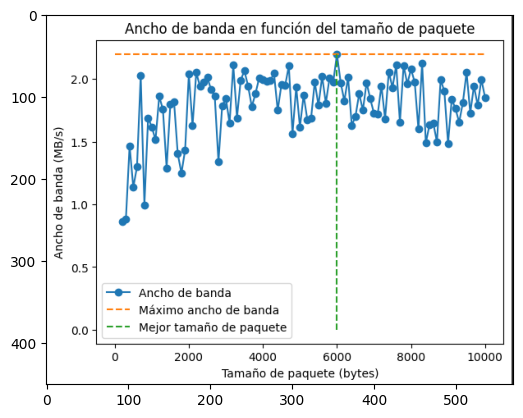

In [29]:
plt.imshow(plt.imread('tarea1.png'));

Con todo esto podemos responder las preguntas.

# Pregunta 1

*Genere algunos experimentos con diversos tamaños de paquete, venta-
na, timeout y pérdidas y haga una recomendación de valores a utilizar
para las distintas pérdidas. Compare con la Tarea1 y con el cliente
stop-and-wait. Grafique sus resultados.*

Lo que queremos estudiar es el ancho de banda, por lo que vamos a graficar esto en el eje z siempre, y el resto de los parámetros los podremos representar de distinta forma:  
- en el eje x: tamaño de paquete
- en el eje y: probabilidad de pérdida
- en el color: timeout
- en el tamaño de los puntos: tamaño de ventana

In [41]:
import plotly.express as px
from copy import deepcopy

In [39]:
fig = px.scatter_3d(
    df,
    x='packet_size',
    y='timeout',
    z='bandwidth',
    color='loss',
    opacity=0.7,
    size='window_size',
    hover_data=['send_time'],
    title='Bandwidth vs packet_size, timeout, loss, window_size',
    labels={
        'packet_size': 'Tamaño de paquete',
        'bandwidth': 'Ancho de banda',
        'timeout': 'Timeout',
        'loss': 'Probabilidad de pérdida',
        'window_size': 'Tamaño de ventana',
        'send_time': 'Tiempo de envío',
    },
    width=1000,
    height=800,
)

fig.update_layout(
    scene = dict(
        xaxis_title='Tamaño de paquete',
        yaxis_title='Timeout',
        zaxis_title='Ancho de banda',
    ),
    scene_aspectmode='cube',
    title={
        'text': 'Bandwidth vs packet_size, timeout, loss, window_size',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)

print()

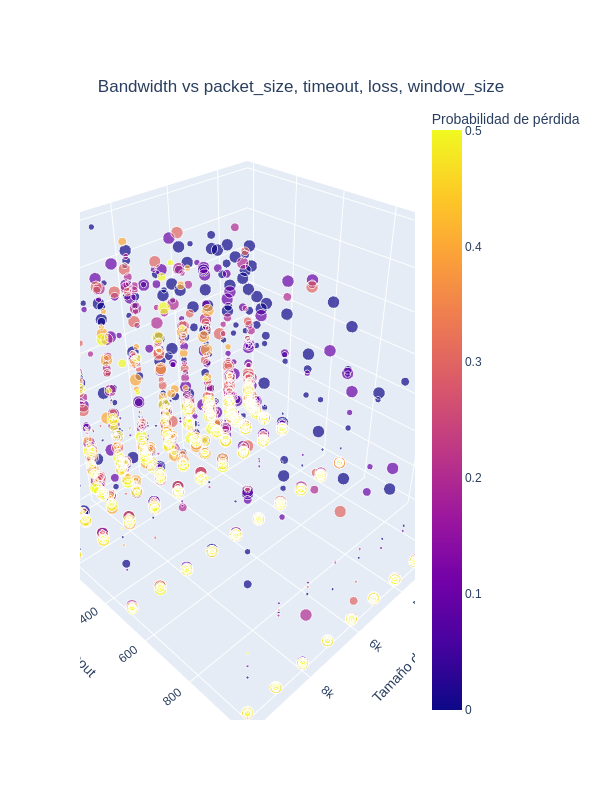

In [44]:
fig.show()

Del gráfico podemos concluir lo siguiente:
- Claramente se ve que a mayor probabilidad de pérdida, menor es el ancho de banda. Esto es porque el protocolo tiene que retransmitir más paquetes.
- El tamaño de ventana se distribuye de forma uniforme o un poco aleatoria, no se ve una tendencia clara y parece depender de los otros parámetros.
- El timeout tampoco se ve una tendencia clara, asi que podemos plotearlo más en específico.

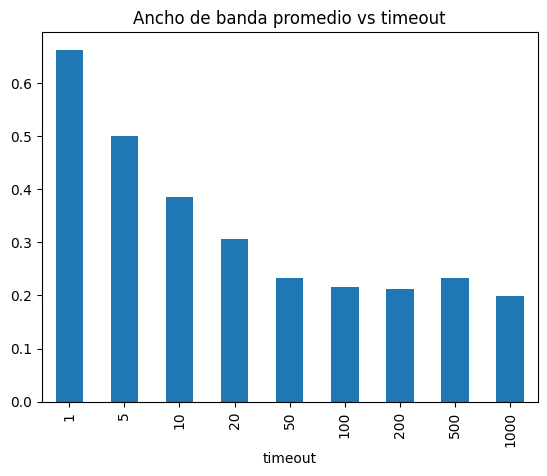

In [53]:
df.groupby('timeout')['bandwidth'].mean().plot.bar(title='Ancho de banda promedio vs timeout');

Vemos que a menor timeout mejor se aprovecha el ancho de banda, esto es porque el protocolo tiene que esperar menos tiempo para retransmitir paquetes. Sin embargo ya vimos que muchos experimentos fallaron para timeout=1, por lo que es mejor descartarlo.

Los puntos interesantes a analizar puede ser:

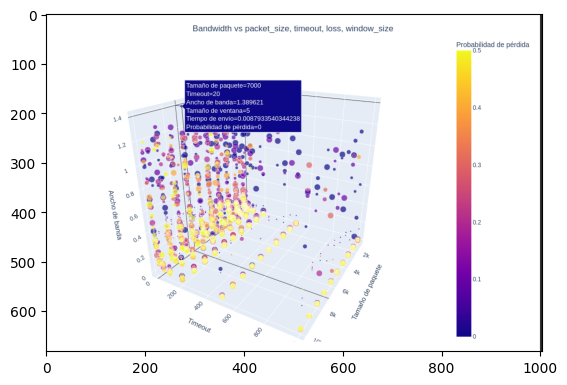

In [57]:
plt.imshow(plt.imread('optimo.png'));

El set de parámetros óptimo encontrado para este experimento es:
- packet_size = 7000
- timeout = 20
- window_size = 5
- loss_prob = 0 (claramente)

Obteniendo un ancho de banda de 1.38 Mbps. 

Esto se condice con el gráfico de la primera tarea, donde el óptimo se encuetra para un packet_size parecido.
Cabe mencionar que los datos tienen ruido a causa de la red, por lo que no podemos asegurar que estos sean los valores óptimos, pero si podemos decir que son los mejores que encontramos.

También nos interesaría estudiar un caso donde haya una probabilidad de pérdida no nula, para ver como se comporta el protocolo cuando las condiciones no son ideales.

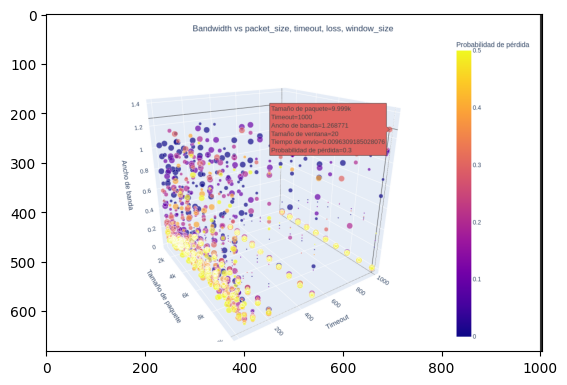

In [58]:
plt.imshow(plt.imread('alto_loss.png'));

En este caso encontramos el siguiente set de parámetros:
- packet_size = 9999
- timeout = 1000
- window_size = 20
- loss_prob = 0.3

Encotramos un ancho de banda de 1.27 Mbps, que es bastante parecido al caso anterior. Esto es porque el protocolo se recupera de las pérdidas de paquetes, por lo que no se ve tan afectado por ellas. Para esto el protocolo prefirió enviar la mayor cantidad de información posible a la vez: el mayor packet_size posible + un buen timeout para esperar el envio de los paquetes + una ventana grande.

Ahora comparemoslo con el stop and wait:

In [65]:
stop_and_wait_df['bandwidth'].describe()

count    3.830000e+02
mean     1.532408e+16
std      1.473602e+16
min      3.017255e+13
25%      3.687372e+15
50%      9.685045e+15
75%      2.307348e+16
max      6.455643e+16
Name: bandwidth, dtype: float64

Claramente estos valores no tienen sentido, por lo que en realidad no se logró usar el cliente stop and wait para este experimento. Pero podemos usar los datos para window_size=1 para compararlos con el cliente Go-Back-N, Ya que este es equivalente al stop and wait.

In [66]:
stopwait = df[df['window_size'] == 1].reset_index(drop=True)

In [67]:
stopwait['bandwidth'].describe()

count    474.000000
mean       0.189270
std        0.159912
min        0.000867
25%        0.031116
50%        0.157953
75%        0.325661
max        0.546041
Name: bandwidth, dtype: float64

In [70]:
con_perdida = stopwait[stopwait['loss'] == 0.3]
sin_perdida = stopwait[stopwait['loss'] == 0]

In [76]:
con_perdida['bandwidth'].describe()

count    80.000000
mean      0.145051
std       0.140508
min       0.001208
25%       0.023036
50%       0.106999
75%       0.237465
max       0.520732
Name: bandwidth, dtype: float64

In [77]:
sin_perdida['bandwidth'].describe()

count    80.000000
mean      0.306648
std       0.116558
min       0.089089
25%       0.217224
50%       0.326369
75%       0.403148
max       0.525344
Name: bandwidth, dtype: float64

De aquí podemos ver que tanto para los casos con pérdida como sin pérdida, el cliente Go-Back-N tiene un mejor ancho de banda que el cliente Stop and Wait. Esto es porque el cliente Go-Back-N puede enviar más de un paquete a la vez, mientras que el cliente Stop and Wait solo puede enviar uno a la vez.

# Pregunta 2

*Discuta si la medición de ancho de banda obtenida es ”válida”: al haber
retransmisiones, ¿estamos midiendo mal? Los resultados obtenidos:
¿son coherentes? ¿se parecen a la realidad? Argumente con sus propias
mediciones realizadas en el punto anterior.*

Si bien el protocolo tiene retransmisiones, estas son necesarias para poder recuperarse de las pérdidas de paquetes. Por lo que no estamos midiendo mal, ya que el protocolo está diseñado para funcionar así. Es cierto que las condiciones son simuladas y que son bastante variables como para poder asegurar que los resultados son válidos, pero si podemos decir que son coherentes con los resultados de la tarea 1 y que se parecen a la realidad (argumentos en los gráficos anteriores)

# Pregunta 3

*Revise si ocurre desorden de paquetes: ¿recibe siempre los ACKs en
orden? Si no es ası́, ¿el protocolo debiera funcionar igual? ¿En algún
caso extremo de desorden podrı́a fallar?*

Revisando los prints podemos ver que en algunos casos los ACKs no llegan en orden, pero esto no afecta al protocolo ya que este solo se preocupa de que llegue un ACK para poder enviar el siguiente paquete. Por lo que el protocolo debiera funcionar igual. Para poder ver este funcionamiento, se puede llamar a la función compute_bandwidth con el parámetro verbose=True.

El desorden extremo podría hacer fallar al protocolo si $MAX_SEQ < window_size$, ya que el receiver podría confundir paquetes del pasado con paquetes del futuro. Pero esto no ocurre en nuestro caso ya aseguramos que un cliente así no se pueda construir. Sin embargo casos extremos pueden existir de todas formas, por lo que el protocolo no es 100% seguro. Por ejemplo podría ocurrir que un paquete con número de secuencia X se quede dando vueltas en la red por mucho tiempo, entonces el sender haría timeout ya que lo daría por perdido, luego lo reenviaría y todo seguiría normal, pero si tenemos suficiente mala suerte puede ocurrir que el paquete que haya quedado dando vueltas llegue al receiver justo cuando este esperaba un paquete con número de secuencia X, por lo que el receiver lo tomaría como válido y lo aceptaría, lo que duplicaría el paquete

# Pregunta 4

*Les pedimos implementar Go-Back-N con ACKs acumulativos. Si uno
no quisiera eso, y quisiera esperar los ACKs uno por uno, ¿funcionarı́a
el protocolo con este servidor? ¿Se puede hacer que funcione?*

A priori el protocolo no funcionaría, ya que el sender no podría saber si el receiver recibió todos los paquetes o no, la gracia de los ACKs acumulativos es que el sender sabe que si llegó un ACK con número de secuencia X, entonces el receiver recibió todos los paquetes con número de secuencia menor a X. Por lo que el sender puede enviar el siguiente paquete sin problemas. Si no fueran acumulativos sería fácil para el receiver confudirse. Sin embargo para arreglarlo tendríamos que mandar un ACK por cada paquete recibido en específico y prácticamente estaríamos implementando un Selective Repeat (obviamente habría que implementar una ventana de recepción para que el receiver no se confunda con los paquetes que llegan). Por lo que si se puede hacer que funcione, pero no sería un Go-Back-N.